In [5]:
using Plots
using QuadGK
using LinearAlgebra

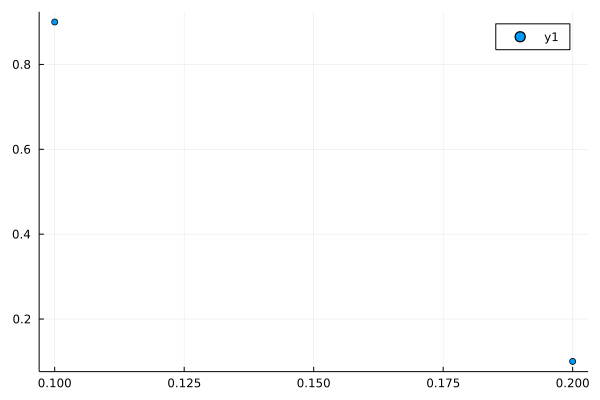

In [51]:
#p = lots() 
scatter([0.1, 0.2], [0.9, 0.1])

In [81]:
nmom = 2
delta1 = 0.1
delta2 = 0.2
Tp = Float64[]
for mom in 0:(nmom-1)
    push!(Tp, (0.1 * (delta1)^mom + 0.9 * (delta2)^mom))
end
Tp

2-element Vector{Float64}:
 1.0
 0.19000000000000003

$$
T^{(n)}_p = (-1)^{n+1} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
S_n = T[0]^{-1/2} T[n] T[0]^{-1/2}
$$

In [82]:
function reconst(T)
    nmom = length(T)
    S = (1/sqrt(T[1])) * T * (1/sqrt(T[1]))
    println(S)

    As = Dict{Int,ComplexF64}()
    Bs = Dict{Int,ComplexF64}()
    Cs = Dict{Tuple{Int,Int},ComplexF64}()

    # Initial values
    As[0] = S[2]
    Bs[0] = 0.0
    Cs[0,0] = 1.0

    function get_S(i)
        i <= nmom-1 ? S[i+1] : 0.0
    end
    
    function get_Cs(n, j)::ComplexF64
        if j < 0 || j > n || n < 0
            return 0.0
        end
        return Cs[(n, j)]
    end

    for n in 0:nmom
        #println("n = $n")
        # Update B[n+1]
        bfirst = sum(conj(Cs[n,l]) * get_S(j+l+1) * get_Cs(n, j-1) for j in 0:(n+1), l in 0:n)
        Bs[n+1] = sqrt(bfirst  - As[n]^2  - conj(Bs[n]^2))

        # C(n+1, j) for j = 0, ..., n+1 (otherwise 0)
        for j in 0:(n+1)
            Cs[(n+1, j)] = (get_Cs(n, j-1) - get_Cs(n, j) * As[n] - get_Cs(n-1, j) * conj(Bs[n])) / Bs[n+1]
        end

        # Update A[n+1]
        As[n+1] = sum(conj(get_Cs(n+1, l) * get_S(j+l+1) * get_Cs(n+1, j)) for j in 0:(n+1), l in 0:(n+1))

        if length(As) >= (nmom + 1) ÷ 2
            break
        end
    end
    return  As, Bs
end

As, Bs = reconst(Tp)

[1.0, 0.19000000000000003]


(Dict{Int64, ComplexF64}(0 => 0.19000000000000003 + 0.0im, 1 => -0.19000000000000003 + 0.0im), Dict{Int64, ComplexF64}(0 => 0.0 + 0.0im, 1 => 0.0 + 0.19000000000000003im))

In [83]:
nc = length(As)
htri = zeros(ComplexF64, nc, nc)
for i in 1:nc
    htri[i, i] = As[i-1]
end
for i in 1:(nc-1)
    htri[i, i+1] = Bs[i]
    htri[i+1, i] = conj(Bs[i])
end

htri

2×2 Matrix{ComplexF64}:
 0.19+0.0im     0.0+0.19im
  0.0-0.19im  -0.19+0.0im

In [84]:
e = eigen(Hermitian(htri))


Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 -0.2687005768508881
  0.2687005768508881
vectors:
2×2 Matrix{ComplexF64}:
      0.0+0.382683im       0.0+0.92388im
 -0.92388+0.0im       0.382683+0.0im

In [85]:
e.values

2-element Vector{Float64}:
 -0.2687005768508881
  0.2687005768508881

In [86]:
weight = real.(conj.(e.vectors[1, :]) .* e.vectors[1, :])

2-element Vector{Float64}:
 0.1464466094067262
 0.8535533905932737

In [87]:
sum(weight)

1.0

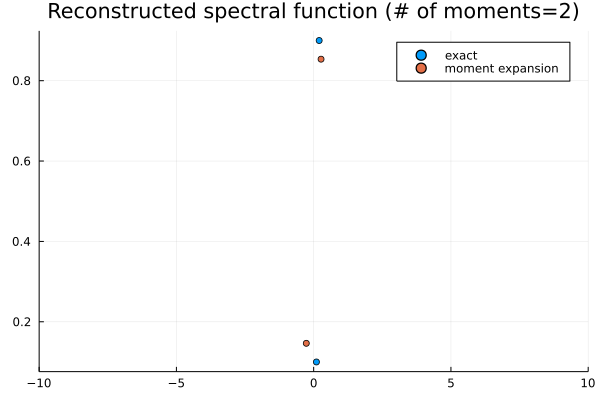

In [88]:

p = plot(xlim=(-10, 10), title = "Reconstructed spectral function (# of moments=$(nmom))")

scatter!(p, [0.1, 0.2], [0.1, 0.9], label="exact")
scatter!(p, [e.values[1], e.values[2]], [weight[1], weight[2]], label="moment expansion")

In [90]:
savefig("$(nmom)")

In [61]:
#δ = 0.35
#gaussian(x, μ) = exp(-0.5 * ((x-μ)/δ)^2)/(sqrt(2π) * δ)
##aomega_reconst = zeros(Float64, length(omegas))
#for ie in eachindex(e.values)
#    aomega_reconst .+= 0.5 * gaussian.(omegas, e.values[ie]) * weight[ie]
#end
#p = plot(xlim=(-wmax, wmax))
#plot!(p, omegas,  (aomega_reconst + reverse(aomega_reconst)), xlim=(-wmax, wmax), marker=:x)
#plot!(p, omegas, aomega.(omegas))